In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import matplotlib.pyplot as plt # this is used for the plot the graph
import imageio.v3 as iio # this is used for image operation
import pydicom as dicom # for medical image analysis
import cv2 # for image processing
from PIL import Image # for image processing
import os # for path manipulation
import dicom2jpg # for converting dicom to jpg
import seaborn as sns # for data visualization
from pathlib import Path # for path manipulation
from sklearn import svm # for machine learning
from sklearn.model_selection import train_test_split # for splitting data into train and test
import torch
import torch.nn as nn
from skimage.transform import resize
import threading
from joblib import dump, load
import cv2

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import sklearn
from sklearn import metrics
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
import seaborn as sn
from pretty_confusion_matrix import pp_matrix

sns.set_style("darkgrid")
sns.set_color_codes("pastel")

In [3]:
df1 = pd.read_csv("data/train.csv")
df1_1 = df1[df1["cancer"] == 1]
df1_0 = df1[df1["cancer"] == 0]
_, df1_0 = train_test_split(df1_0, test_size=0.05, random_state=47)

In [4]:
df2 = pd.read_csv("../archive/csv/calc_case_description_train_set.csv")
df2["pathology"] = df2["pathology"].apply(lambda x: int(x == 'MALIGNANT'))
df2_1 = df2[df2["pathology"] == 1]
folders2 = df2_1["image file path"].apply(lambda x: "../archive/jpeg/" + x.split("/")[-2])
files = []
for folder in folders2:
    for file in os.listdir(folder):
        files.append(folder+"/"+file)

In [5]:
os.listdir(folders2[0])

['1-188.jpg']

In [6]:
files_0 = [str(df1_0.iloc[x]['patient_id']) + '/' + str(df1_0.iloc[x]['image_id']) + '.dcm' for x in range(len(df1_0))]

In [7]:
files_1 = [str(df1_1.iloc[x]['patient_id']) + '/' + str(df1_1.iloc[x]['image_id']) + '.dcm' for x in range(len(df1_1))]

In [8]:
files_1.extend(files)

In [9]:
_path = Path("../train_images/")

In [10]:
# def create_rgb_matrixes(row, col):
# 	r_matrix = np.zeros((row, col), dtype=np.uint8)
# 	g_matrix = np.zeros((row, col), dtype=np.uint8)
# 	b_matrix = np.zeros((row, col), dtype=np.uint8)
# 	return r_matrix, g_matrix, b_matrix

In [11]:
def thresholding(img, measure):
    row, col = img.shape
    th_image = np.zeros((row, col))

    for i in range(row):
        for j in range(col):
            if img[i, j] < int(measure):
                th_image[i, j] = 0
            else:
                th_image[i, j] = 255

    return th_image

In [12]:
def thresholding_v2(img, measure):

    img[img < int(measure)] = 0
    img[img > int(measure)] = 255

    return img

In [13]:
def create_yiq_matrixes(row, col):
    y_matrix = np.zeros((row, col))
    i_matrix = np.zeros((row, col))
    q_matrix = np.zeros((row, col))
    return y_matrix, i_matrix, q_matrix

def convert_to_yiq(img):
    row, col = img.shape
    blue, green, red = cv2.split(img)
    
    y_matrix, i_matrix, q_matrix = create_yiq_matrixes(row, col)
    for i in range(row):
        for j in range(col):
            r = red[i, j]
            g = green[i, j]
            b = blue[i, j]
            # RGB to YIQ
            y_matrix[i, j] = (0.299 * r) + (0.587 * g) + (0.114 * b)
            i_matrix[i, j] = (0.596 * r) - (0.274 * g) - (0.322 * b)
            q_matrix[i, j] = (0.211 * r) - (0.523 * g) + (0.312 * b)

    return y_matrix, i_matrix, q_matrix


def thresholding_y(img, measure):
    y_matrix, i_matrix, q_matrix = convert_to_yiq(img)
    
    y_matrix = img.copy()
    y_matrix[img < int(measure)] = 0
    y_matrix[img > int(measure)] = 255
    
    return cv2.merge([y_matrix, i_matrix, q_matrix])

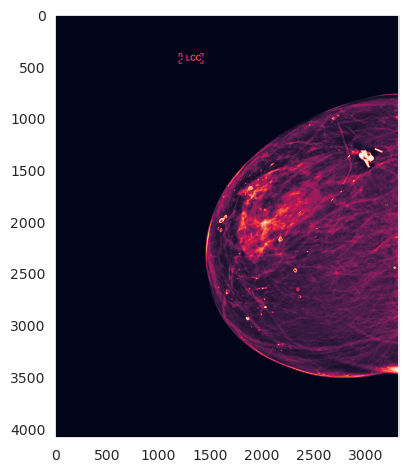

In [14]:
example = _path.__str__() + "/" + files_1[1]

ds = dicom.dcmread(example)
ds.decompress('gdcm')
image_as_np = ds.pixel_array.astype(np.float32)

plt.imshow(image_as_np)
plt.grid(False)

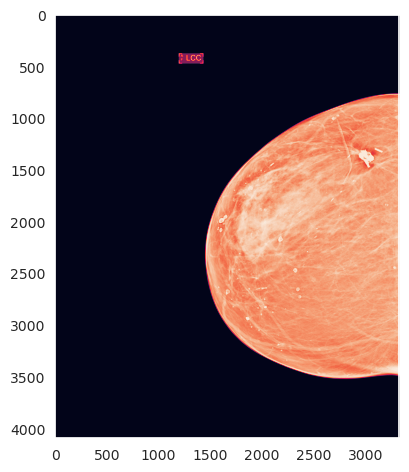

In [15]:
# Apply log transformation method
c = 255 / np.log(1 + np.max(image_as_np))
log_image = c * (np.log(image_as_np + 1))
   
# Specify the data type so that
# float value will be converted to int
log_image = np.array(log_image, dtype = np.uint8)

plt.imshow(log_image)
plt.grid(False)

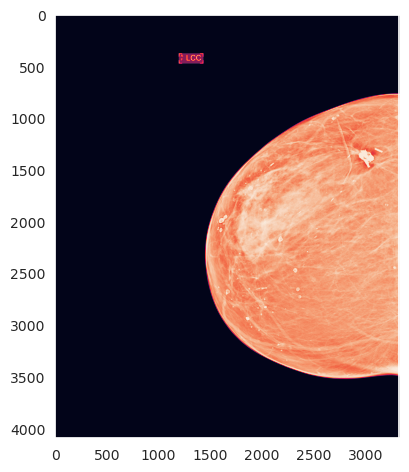

In [39]:
img = np.array(255*(log_image/255)*0.7,dtype='uint8')
plt.imshow(img)
plt.grid(False)

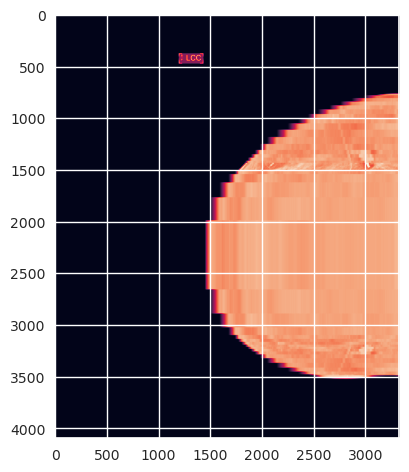

In [38]:
closing = cv2.morphologyEx(img, cv.MORPH_CLOSE, kernel)

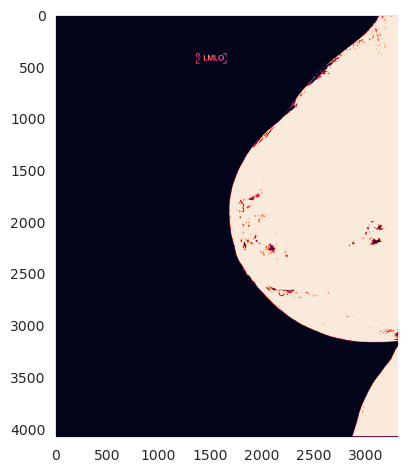

In [19]:
example = _path.__str__() + "/" + files_1[0]

ds = dicom.dcmread(example)
ds.decompress('gdcm')
image_as_np = ds.pixel_array.astype(np.float32)

image_as_np = thresholding_v2(image_as_np, 255)

plt.imshow(image_as_np)
plt.grid(False)

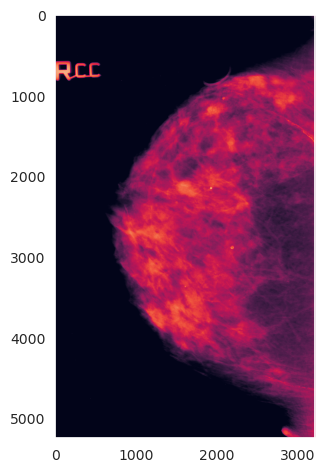

In [35]:
example = _path.__str__() + "/" + files_1[-10]

img = Image.open( example )
img.load()
image_as_np = np.asarray( img, dtype="int32" )

plt.imshow(image_as_np)
plt.grid(False)

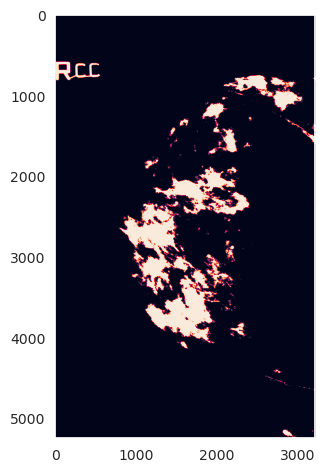

In [36]:
example = _path.__str__() + "/" + files_1[-10]

img = Image.open( example )
img.load()
image_as_np = np.asarray( img, dtype="int32" )

image_as_np = thresholding_v2(image_as_np, 127)

plt.imshow(image_as_np)
plt.grid(False)

In [39]:
def open_files(list_of_files, images_array, erros, index_start):
    print(f"> {index_start} Start thread")
    for i, image in enumerate(list_of_files):
        try:
            image_path = _path.__str__() + '/' + image
            try:
                ds = dicom.dcmread(image_path)
                ds.decompress('gdcm')
                image_as_np = ds.pixel_array.astype(np.float32)

                image_as_np = thresholding_v2(image_as_np, 255)
            except:
                img = Image.open( image_path )
                img.load()
                image_as_np = np.asarray( img, dtype="int32" )

                image_as_np = thresholding_v2(image_as_np, 127)

            image_as_np = resize(image_as_np, (204, 166), anti_aliasing=True)

            images_array[index_start+i] = image_as_np
        except Exception as e:
            print("\nError:", image)
            erros += 1
            raise e
    print(f"> [index_start] End thread")

In [40]:
images_array_0 = [np.zeros((204, 166))]*len(files_0)
erros = 0

open_files(files_0,
            images_array_0,
            erros,
            0)

dump(images_array_0, r"./images_thresholding_array_0.hdf5")
del images_array_0


> 0 Start thread
> [index_start] End thread


In [41]:
images_array_1 = [np.zeros((204, 166))]*len(files_1)
erros_test = 0

open_files(files_1,
            images_array_1,
            erros_test,
            0)

dump(images_array_1, r"./images_thresholding_array_1.hdf5")
del images_array_1

> 0 Start thread
> [index_start] End thread


In [42]:
X_0 = load(r"./images_thresholding_array_0.hdf5")
X_1 = load(r"./images_thresholding_array_1.hdf5")
y = [0]*len(X_0) + [1]*len(X_1)

X = np.array(X_0+X_1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

## SVM

#### Testing

In [43]:
svm_model = svm.SVC()

In [44]:
svm_model.fit(X_train.reshape(len(X_train), -1), y_train)

SVC()

In [45]:
y_pred = svm_model.predict(X_test.reshape(len(X_test), -1))

In [46]:
metrics.accuracy_score(y_test, y_pred)

0.7408675799086758

In [47]:
metrics.confusion_matrix(y_test, y_pred)

array([[539,   1],
       [226, 110]])

#### Grid Search

In [48]:
svm_model = svm.SVC()

parameters = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

clf = GridSearchCV(svm_model, parameters)

In [49]:
clf.fit(X_train.reshape(len(X_train), -1), y_train)

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}])

In [50]:
clf.best_score_

0.7340195638883229

In [51]:
clf.best_estimator_

SVC(C=1, gamma=0.001)

In [52]:
svm_model = svm.SVC()

parameters = [
  {'C': [1, 10, 100, 1000], 'gamma': ['scale'], 'kernel': ['rbf']},
 ]

clf = GridSearchCV(svm_model, parameters)

In [53]:
clf.fit(X_train.reshape(len(X_train), -1), y_train)

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': ['scale'],
                          'kernel': ['rbf']}])

In [54]:
clf.best_score_

0.7337342571836152

In [55]:
clf.best_estimator_

SVC(C=1)

In [56]:
svm_model = svm.NuSVC()

parameters = [
  {'nu': [0.1, 0.5, 0.8, 1], 'kernel': ['linear']},
  {'nu': [0.1, 0.5, 0.8, 1], 'gamma': [0.001, 0.0001, 'scale', 'auto'], 'kernel': ['rbf']},
]

clf = GridSearchCV(svm_model, parameters)

In [57]:
clf.fit(X_train.reshape(len(X_train), -1), y_train)

/home/gabriel/anaconda3/envs/mineracao/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/home/gabriel/anaconda3/envs/mineracao/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/gabriel/anaconda3/envs/mineracao/lib/python3.8/site-packages/sklearn/svm/_base.py", line 252, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/home/gabriel/anaconda3/envs/mineracao/lib/python3.8/site-packages/skl

GridSearchCV(estimator=NuSVC(),
             param_grid=[{'kernel': ['linear'], 'nu': [0.1, 0.5, 0.8, 1]},
                         {'gamma': [0.001, 0.0001, 'scale', 'auto'],
                          'kernel': ['rbf'], 'nu': [0.1, 0.5, 0.8, 1]}])

In [58]:
clf.best_score_

0.7340195638883229

In [59]:
clf.best_estimator_

NuSVC(gamma=0.001, nu=0.1)

In [60]:
import scipy

In [61]:
from sklearn.utils.fixes import loguniform

In [64]:
svm_model = svm.SVC()

parameters = {
  'C': loguniform(1e0, 1e3),
  'gamma': loguniform(1e-4, 1e-3),
  'kernel': ['rbf'],
  'class_weight':['balanced', None]}

clf = RandomizedSearchCV(svm_model, parameters)

In [65]:
clf.fit(X_train.reshape(len(X_train), -1), y_train)

RandomizedSearchCV(estimator=SVC(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f57a6cde5e0>,
                                        'class_weight': ['balanced', None],
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f57a6d076a0>,
                                        'kernel': ['rbf']})

In [66]:
clf.best_score_

0.7340195638883229

In [67]:
clf.best_estimator_

SVC(C=14.355746278872186, gamma=0.00022108413576901978)

 SVM - 74.2%
 LSTM - 67.4%
 XGBOOST - ?
 CNN - ?
 YOLO - ?